# Topic modeling for tags

1. Content aggregation: By scraping news headlines and tags from multiple sources, it is possible to create a news aggregation platform that provides a comprehensive overview of the latest stories on a variety of topics.

2. Sentiment analysis: By analyzing the sentiment of news headlines over time, it is possible to track changes in public opinion on various topics. This could be useful for businesses, governments, and other organizations that want to understand how their actions or policies are being received by the public.

3. Market research: By tracking the frequency and content of news articles related to specific industries or companies, it is possible to gain insights into market trends and the performance of individual firms.

4. Media monitoring: By tracking the publication of news articles related to a specific person, company, or topic, it is possible to monitor media coverage and respond to any negative or false information that may be published.

5. Data visualization: By visualizing the volume and content of news articles over time, it is possible to create graphical representations of trends and patterns in the news. This could be useful for journalists, researchers, or anyone interested in understanding how a particular topic has evolved over time.

How does a topic evolve over time?

In [86]:
import pandas as pd
from collections import Counter
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
sns.set_theme(style="ticks")
sns.set_palette("Paired")

from typing import List, Dict

In [87]:
def flatten(l):
    return [item for sublist in l for item in sublist]

In [88]:
# load cleaned dataset
df_news = pd.read_parquet("data/news/tagesschau/2022/tagesschau-news.parquet")
df_news['tags'] = df_news['tags'].apply(lambda x: x.split(','))

# What are the top tags?
df_top_n_tags_for_2022 = pd.read_parquet("data/news/tagesschau/2022/tagesschau-top-tags.parquet")

In [120]:
def find_cooccurring_tags(article_tags: List[List[str]], target_tag: str, duplicates: bool=True) -> List[str]:
    """
    Finds all tags and their frequency that co-occur with the target tag in a list of article tags. 
    
    Parameters:
        - article_tags (list of list): List of lists where each list contains tags of an article.
        - target_tag (str): The tag for which co-occurring tags need to be found.
        - duplicates (bool): If False, return each co-occurring tag just once.
    
    Returns:
        - list: A list of co-occurring tags.
    """
    cooccurring_tags = []
    for tags in article_tags:
        if target_tag in tags:
            for tag in tags:
                if tag != target_tag:
                        cooccurring_tags.append(tag)
    if duplicates:
        return cooccurring_tags
    else:
        return list(set(cooccurring_tags))

def calculate_relative_counts(tags: List[str]) -> Dict[str, float]:
    """
    Given a list of tags, it returns a dictionary of relative frequency of each tag in the list.

    Parameters:
    - tags (List[str]): A list of tags whose relative frequency needs to be calculated.

    Returns:
    - Dict[str, float]: A dictionary of relative frequency of each tag.
    """
    tag_counter = Counter(tags)
    total_count = sum(tag_counter.values())
    relative_counts = {tag: count/total_count for tag, count in tag_counter.items()}
    return relative_counts


def calculate_absolute_counts(tags: List[str]) -> Dict[str, float]:
    """
    Given a list of tags, it returns a dictionary of absolute frequency of each tag in the list.

    Parameters:
    - tags (List[str]): A list of tags whose absolute frequency needs to be calculated.

    Returns:
    - Dict[str, float]: A dictionary of absolute frequency of each tag.
    """
    absolute_counts = Counter(tags)
    return dict(absolute_counts)


def get_cooccurring_counts(article_tags: List[str], target_tag: str) -> pd.DataFrame:
    """
    Given a list of tags and a target tag, it returns a DataFrame containing the relative and absolute counts 
    of co-occurring tags and target tag.

    Parameters:
    - tags (List[str]): A list of tags whose co-occurring tags needs to be calculated.
    - target_tag (str): The target tag whose co-occurring tags need to be calculated

    Returns:
    - pd.DataFrame: A DataFrame containing the relative and absolute counts of co-occurring tags and target tag.
    """
    cooccurring_tags = find_cooccurring_tags(article_tags, target_tag)
    df_cooccurring_tags = pd.DataFrame({
        'relative_count': calculate_relative_counts(cooccurring_tags),
        'absolute_count': calculate_absolute_counts(cooccurring_tags)
        }).reset_index().rename(columns={'index': 'cooccurring_tag'})
    df_cooccurring_tags['tag'] = target_tag
    return df_cooccurring_tags.sort_values('absolute_count', ascending=False).reset_index(drop=True)

def get_cooccurring_tag_counts_matrix(article_tags: List[str], target_tags: List[str]) -> pd.DataFrame:
    cooccurring_tag_counts_matrix = pd.DataFrame()
    for target_tag in target_tags:
        cooccurring_tag_counts = get_cooccurring_counts(article_tags, target_tag)
        cooccurring_tag_counts_matrix = pd.concat([cooccurring_tag_counts_matrix, cooccurring_tag_counts], axis=0)
    return cooccurring_tag_counts_matrix

def test_cooccurring_tag_counts_matrix():
    article_tags = [
        ["Papst Benedikt XVI.", "Vatikan", "Papst"],
        ["Ukraine", "Angriffe", "Russland", "Kiew"],
        ["Ukraine", "Russland"]
    ]
    target_tags = ["Russland", "Papst"]
    cooccurring_tag_counts_matrix = get_cooccurring_tag_counts_matrix(article_tags, target_tags)
    return cooccurring_tag_counts_matrix

In [121]:
cooccurring_tag_counts_matrix = get_cooccurring_tag_counts_matrix(article_tags=df_news['tags'], target_tags=df_top_n_tags_for_2022['tag'])

In [124]:
cooccurring_tag_counts_matrix.query("relative_count > 0.01")

,cooccurring_tag,relative_count,absolute_count,tag
0,Russland,0.146382,967,Ukraine
1,Liveblog,0.046019,304,Ukraine
2,Krieg,0.040418,267,Ukraine
3,Ukraine-Krieg,0.034514,228,Ukraine
4,Mariupol,0.018317,121,Ukraine
...,...,...,...,...
9,Aktien,0.015697,24,Börse
10,Kurssturz,0.014388,22,Börse
11,Tesla,0.013734,21,Börse
12,Geldanlage,0.013734,21,Börse


<AxesSubplot:xlabel='absolute_count', ylabel='cooccurring_tag'>

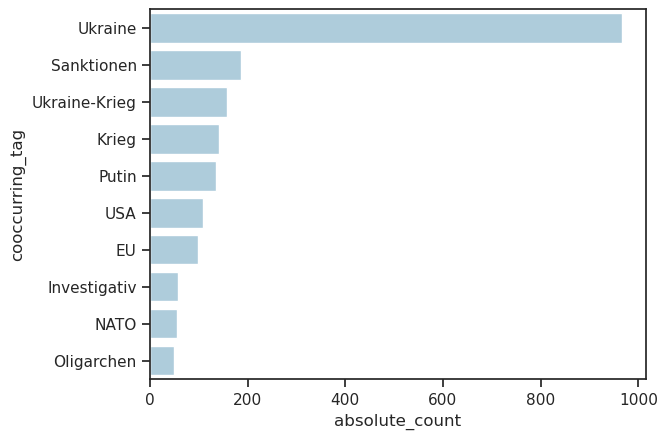

In [123]:
fig, ax = plt.subplots()
sns.barplot(data=cooccurring_tag_counts_matrix.query("(relative_count > 0.01) & (tag == 'Russland')"), y='cooccurring_tag', x='absolute_count', color='C0')

## Analyze the intersection between topics based on the related tags

Let's assume that the topics are represented by the most frequently used tags throughout the year. Following this idea, *Ukraine*, *Russland* or *Coronavirus* are examples for topics in the last year. While *Coronavirus* and *Ukraine* can be most likely treated as independent topics, *Russland* and *Ukraine*, on the other hand, are strongly correlated. The topic quality can be increased by merging correlating topics, such that ultimately only topics remain that differentiate strongly from one another. 
For this reason, a metric that quantifies the overlap between topic pairs is necessary. For the first attempt, the overlap between two sets of co-occurring tags corresponding to a topic pair can be utilized as a similarity measure. 

In [125]:
topics = df_top_n_tags_for_2022['tag']
print(topics)

0           Ukraine
1          Russland
2       Coronavirus
3               USA
4      Energiekrise
5                EU
6     Ukraine-Krieg
7             China
8          Liveblog
9         Inflation
10     Investigativ
11            Krieg
12              DAX
13           Scholz
14            Börse
Name: tag, dtype: object


There are several ways to create all pairs from a list in Python, depending on the desired output format and level of complexity. Here we are using the module itertools

In [126]:

topic_pairs = list(itertools.combinations(topics, 2))
print(topic_pairs)


[('Ukraine', 'Russland'), ('Ukraine', 'Coronavirus'), ('Ukraine', 'USA'), ('Ukraine', 'Energiekrise'), ('Ukraine', 'EU'), ('Ukraine', 'Ukraine-Krieg'), ('Ukraine', 'China'), ('Ukraine', 'Liveblog'), ('Ukraine', 'Inflation'), ('Ukraine', 'Investigativ'), ('Ukraine', 'Krieg'), ('Ukraine', 'DAX'), ('Ukraine', 'Scholz'), ('Ukraine', 'Börse'), ('Russland', 'Coronavirus'), ('Russland', 'USA'), ('Russland', 'Energiekrise'), ('Russland', 'EU'), ('Russland', 'Ukraine-Krieg'), ('Russland', 'China'), ('Russland', 'Liveblog'), ('Russland', 'Inflation'), ('Russland', 'Investigativ'), ('Russland', 'Krieg'), ('Russland', 'DAX'), ('Russland', 'Scholz'), ('Russland', 'Börse'), ('Coronavirus', 'USA'), ('Coronavirus', 'Energiekrise'), ('Coronavirus', 'EU'), ('Coronavirus', 'Ukraine-Krieg'), ('Coronavirus', 'China'), ('Coronavirus', 'Liveblog'), ('Coronavirus', 'Inflation'), ('Coronavirus', 'Investigativ'), ('Coronavirus', 'Krieg'), ('Coronavirus', 'DAX'), ('Coronavirus', 'Scholz'), ('Coronavirus', 'Börse

In [178]:
from typing import Literal, Union

In [185]:
def similarity_score_sample_sets(set1: set, set2: set, method: Literal["jaccard", "overlap", "dice"]="jaccard") -> Dict[str, Union[float,str,List[str]]]:
    if method == "jaccard":
        score = len(set1.intersection(set2)) / len(set1.union(set2))
    elif method == "overlap":
        score = len(set1.intersection(set2)) / min(len(set1), len(set2))
    elif method == "dice":
        score = 2 * len(set1.intersection(set2)) / (len(set1) + len(set2))
    else:
        raise ValueError(f"Method {method} not known.")
    
    return score

def get_similarity_for_topic_pair(topic_pair: tuple, threshold_relative_count: float=0.05, method: Literal["jaccard", "overlap", "dice"]="jaccard"):
    set1, set2 = [set(cooccurring_tag_counts_matrix.query("(relative_count > @threshold_relative_count) & (tag == @topic)")['cooccurring_tag']) for topic in topic_pair]
    tag_intersection = list(set1.intersection(set2))
    similarity_score = similarity_score_sample_sets(set1,set2, method=method)
    return {'tags': tag_intersection, 'similarity': similarity_score, 'method': method}

In [186]:
multi_index = pd.MultiIndex.from_tuples(topic_pairs)
topic_pair_similarity = pd.DataFrame(data={'tags': None, 'similarity': None}, index=multi_index)

for topic_pair in topic_pairs:
    similarity_for_topic_pair = get_similarity_for_topic_pair(topic_pair, method='overlap')
    topic_pair_similarity.loc[topic_pair, 'tags'] = similarity_for_topic_pair['tags']
    topic_pair_similarity.loc[topic_pair, 'similarity'] = similarity_for_topic_pair['similarity']



In [187]:
topic_pair_similarity

tags  \
Ukraine Russland      [Krieg, USA, Sanktionen, Mariupol, Ukraine-Kri...   
        Coronavirus                                     [Liveblog, USA]   
        USA                     [Sanktionen, NATO, Russland, Biden, EU]   
        Energiekrise                 [Sanktionen, Scholz, EU, Russland]   
        EU            [USA, Sanktionen, Ukraine-Krieg, Scholz, NATO,...   
...                                                                 ...   
Krieg   Scholz        [Ukraine, Russland, Putin, Kiew, Deutschland, EU]   
        Börse                                       [Ukraine, Russland]   
DAX     Scholz                    [China, Inflation, Russland, Ukraine]   
        Börse         [Marktbericht, Tesla, Euro, Fed, Gaskrise, Inf...   
Scholz  Börse                            [Inflation, Russland, Ukraine]   

                     similarity  
Ukraine Russland       0.608696  
        Coronavirus    0.083333  
        USA            0.227273  
        Energiekrise   0.166667  
        EU                0.375  
...                         ...  
Krieg   Scholz              0.3  
        Börse               0.1  
DAX     Scholz            0.125  
        Börse          0.965517  
Scholz  Börse          0.103448  

[105 rows x 2 columns]

The Jaccard similarity, the overlap coefficient, and the Dice coefficient are all measures of similarity between two sets. However, they are defined slightly differently, and thus have different properties.

Jaccard similarity: This is defined as the size of the intersection of two sets divided by the size of the union of the two sets. It ranges from 0 to 1, with a value of 1 indicating that the two sets are identical and a value of 0 indicating that they have no elements in common. Jaccard similarity is sensitive to the relative size of the two sets, and it tends to favor smaller sets.

Overlap coefficient: This is defined as the size of the intersection of two sets divided by the smaller of the two set sizes. It ranges from 0 to 1, with a value of 1 indicating that the two sets are identical and a value of 0 indicating that they have no elements in common. The overlap coefficient is less sensitive to the relative size of the two sets than Jaccard similarity.

Dice coefficient: This is defined as twice the size of the intersection of two sets divided by the sum of the sizes of the two sets. It ranges from 0 to 1, with a value of 1 indicating that the two sets are identical and a value of 0 indicating that they have no elements in common. Dice coefficient is similar to the overlap coefficient, but it tends to be slightly more sensitive to the relative size of the two sets than the overlap coefficient.

In general, Jaccard similarity, Overlap coefficient, and Dice coefficient all gives the same results but they are sensitive to the different situations. Jaccard similarity is best used when both sets are of similar size and you want to give equal weight to the presence and absence of elements. Overlap coefficient is best used when both sets are of different size and you want to give more weight to the presence of elements. Dice coefficient is best used when both sets are of similar size and you want to give more weight to the presence of elements.

### Evaluate the similarity measure

In [189]:
topic_pair_similarity.query("similarity > 0.5")

tags  \
Ukraine  Russland       [Krieg, USA, Sanktionen, Mariupol, Ukraine-Kri...   
         Ukraine-Krieg  [Cherson, Flüchtlinge, Liveblog, Charkiw, Sank...   
Russland Ukraine-Krieg  [USA, Sanktionen, China, Scholz, Energie, NATO...   
China    Liveblog       [Corona, Corona-Pandemie, Ukraine-Krieg, Ukrai...   
Liveblog Investigativ   [Corona-Pandemie, Ukraine-Krieg, Ukraine, Russ...   
         Scholz           [Coronavirus, Ukraine-Krieg, Russland, Ukraine]   
DAX      Börse          [Marktbericht, Tesla, Euro, Fed, Gaskrise, Inf...   

                       similarity  
Ukraine  Russland        0.608696  
         Ukraine-Krieg   0.727273  
Russland Ukraine-Krieg   0.590909  
China    Liveblog             1.0  
Liveblog Investigativ    0.833333  
         Scholz          0.666667  
DAX      Börse           0.965517

In [13]:
aggregated_topics = pd.DataFrame(df_tag_mapping.query("score > 0.5").index.tolist(), columns=['tag_1', 'tag_2'])\
    .groupby('tag_1')\
    .agg(lambda x: ','.join(x)).reset_index()\
    .apply(lambda x: ','.join(x), axis=1)\
    .tolist()

In [14]:
print("Topics: ", topics)
print("Aggregated topics: ", aggregated_topics)

Topics:  ['Ukraine', 'Russland', 'Coronavirus', 'USA', 'Energiekrise', 'EU', 'Ukraine-Krieg', 'China', 'Liveblog', 'Inflation', 'Investigativ', 'Krieg', 'DAX', 'Scholz', 'Börse']
Aggregated topics:  ['DAX,Börse', 'Liveblog,Investigativ,Scholz', 'Ukraine,Russland,Ukraine-Krieg']


In [15]:
topics_to_remove = ','.join(aggregated_topics).split(',')
new_topics = list(set(topics).difference(set(topics_to_remove)).union(aggregated_topics))
print("New topics: ", new_topics)

New topics:  ['Coronavirus', 'Liveblog,Investigativ,Scholz', 'Krieg', 'USA', 'China', 'Inflation', 'DAX,Börse', 'Energiekrise', 'EU', 'Ukraine,Russland,Ukraine-Krieg']


In [16]:
df_topics = pd.DataFrame(columns=['topic','tag','count'])
for topic in new_topics:
    df_tmp = pd.DataFrame()
    df_tmp[['tag', 'count']] = df_source_target_mapping.query("source in @topic.split(',')")[['target', 'count']].values
    df_tmp['topic'] = topic
    df_topics = pd.concat([df_topics, df_tmp])
    
df_topics = df_topics.groupby(['topic', 'tag']).agg({'count': 'sum'}).reset_index()
df_topics['rel_count'] = df_topics.groupby('topic')['count'].transform(lambda x: x / x.sum())
df_topics['rank'] = df_topics.groupby('topic')['count'].rank(method='average', ascending=False)
df_topics = df_topics.sort_values(['topic','rank'], ascending=[True, True]).set_index(['topic', 'rank'])
# test
# df_tmp.groupby('topic').agg({'rel_count': 'sum'})

In [17]:
df_topics

tag count rel_count
topic                          rank                               
China                          1.0     Coronavirus    86  0.071786
                               2.0        Russland    43  0.035893
                               3.0          Taiwan    37  0.030885
                               4.0             USA    27  0.022538
                               6.0        Lockdown    24  0.020033
...                                            ...   ...       ...
Ukraine,Russland,Ukraine-Krieg 1308.5        Ärzte     1  0.000079
                               1308.5   Ölkonzerne     1  0.000079
                               1308.5    Übernahme     1  0.000079
                               1308.5       Новини     1  0.000079
                               1308.5      Новости     1  0.000079

[6283 rows x 3 columns]

# Evolution of tags
Create a slope graph to show the evolution of tag occurrence between the current and previous month.

In [18]:
import pickle

In [19]:
with open('data/news/tagesschau/2022/summed_tags.pkl', 'rb') as handle:
    summed_tags = pickle.load(handle)


In [20]:
summed_tags['monthly'][summed_tags['monthly'].index.month == 1]


,allTagsPerMonth,tags_frequency
timestamp,,
2022-01-31,"[Silvester, 2021, Neujahr, G7, Russland, China...","{'Silvester': 5, '2021': 6, 'Neujahr': 3, 'G7'..."


In [21]:
mask = summed_tags['monthly'].index.month == 5
tag_counts_5 = summed_tags['monthly'].loc[mask, 'tags_frequency'].item()

mask = summed_tags['monthly'].index.month == 6
tag_counts_6 = summed_tags['monthly'].loc[mask, 'tags_frequency'].item()

mask = summed_tags['monthly'].index.month == 7
tag_counts_7 = summed_tags['monthly'].loc[mask, 'tags_frequency'].item()

mask = summed_tags['monthly'].index.month == 8
tag_counts_8 = summed_tags['monthly'].loc[mask, 'tags_frequency'].item()

In [36]:
df = pd.DataFrame(tag_counts_8.most_common(4), columns=['tag', 'counts_8']).set_index('tag')

In [37]:
df['counts_5'] = 0
df['counts_6'] = 0
df['counts_7'] = 0

for tag in df.index:
    df.loc[tag, 'counts_5'] = tag_counts_5[tag]
    df.loc[tag, 'counts_6'] = tag_counts_6[tag]
    df.loc[tag, 'counts_7'] = tag_counts_7[tag]
    

## Slope graph

In [38]:
import numpy as np
from datetime import date

In [39]:
# # Define the x and y values for the slope
# x = [date(2021,1,1), date(2022,1,1)]
# y = [np.random.randint(1,10, size=len(x)) for _ in range(4)]
# index = x
# labels = [f"Label {i}" for i in range(4)]
# values = y
# df = pd.DataFrame(data={label: value for label, value in zip(labels, values)}, index=index)

In [40]:
def plot_slope_graph(x, y, labels, xticks=None):
    # Create the plot
    if xticks is None:
        xticks = x
    labels_coords = []
    label_counter = {key: 0 for key in [y_[0] for y_ in y]}
    y_offset = 0
    num_digits = len(str(np.max([y_[0] for y_ in y])))
    x_offset = -25 - (5 * num_digits)
    fig, ax = plt.subplots(figsize=(6,8), tight_layout=True)
    for i, y_ in enumerate(y):
        if y_[1] > y_[0]:
            color = 'C0'
            weight = 'bold'
        else:
            color = 'grey'
            weight = 'normal'
        ax.plot(x, y_, color=color, linewidth=3)
        ax.scatter([x[0],x[-1]], [y_[0],y_[-1]], c=color, marker='o', s=100)
        ax.annotate(f"{y_[0]}", xy=(x[0],y_[0]), xytext=(-10,0), textcoords='offset points', horizontalalignment='right', verticalalignment='center', color=color, weight=weight)
        ax.annotate(f"{y_[-1]}", xy=(x[-1],y_[-1]), xytext=(10,0), textcoords='offset points', horizontalalignment='left', verticalalignment='center', color=color, weight=weight)
        
        
        label_coords = (x[0],y_[0])
        label_y_offset = y_offset
        if label_coords in labels_coords:
            label_counter[y_[0]] +=1
            y_offset = 15 * label_counter[y_[0]]
        else:
            y_offset = 0
        ax.annotate(labels[i], xy=label_coords, xytext=(x_offset,0-y_offset), textcoords='offset points', horizontalalignment='right', verticalalignment='center', color=color)
        labels_coords.append((x[0],y_[0]))
        # labels['y_offset'].append(y_offset)
    # if x_label is not None:
    #     ymax = np.max([y_[0] for y_ in y])
    #     ax.annotate(x_label, xy=(x[0],ymax), xytext=(x_offset,30), textcoords='offset points', horizontalalignment='right', verticalalignment='center', color=color)
    #     ax.annotate("|", xy=(x[0],ymax), xytext=(x_offset+5,30), textcoords='offset points', horizontalalignment='center', verticalalignment='center', color=color)
    # if y_label is not None:
    #     ymax = np.max([y_[0] for y_ in y])
    #     ax.annotate(y_label, xy=(x[0],ymax), xytext=(-10,30), textcoords='offset points', horizontalalignment='right', verticalalignment='center', color=color)
    # plt.xticks(x, xticks)
    # remove the y-axis
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    # plt.gca().spines['top'].set_visible(False)

    # remove the y-axis
    ax.yaxis.set_visible(False)
    return fig, ax


In [41]:
import calendar

In [42]:
y = df[['counts_5', 'counts_6','counts_7','counts_8']].values
x = [calendar.month_abbr[month_num] for month_num in [5,6,7,8]]
labels = df.index

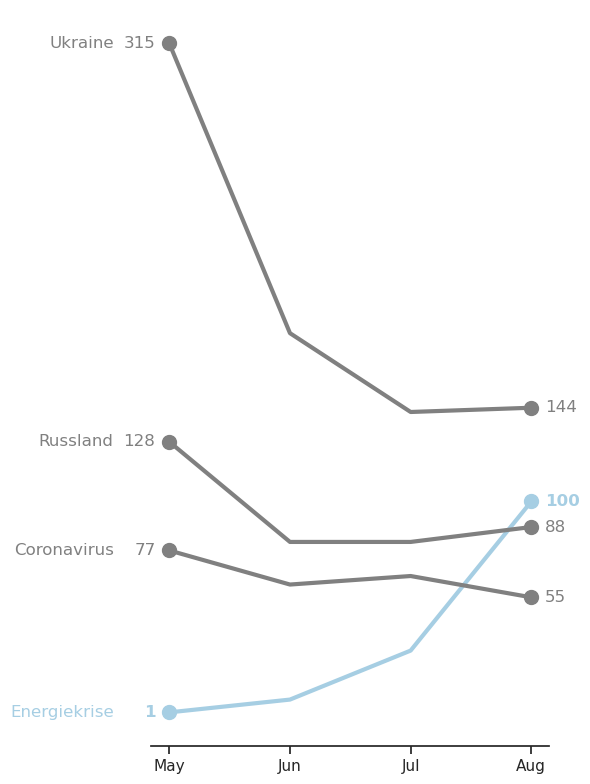

In [43]:
fig, ax = plot_slope_graph(x,y,labels)

In [ ]:
fig.get_figwidth()

6.0

In [ ]:
fig.savefig("data/news/tagesschau/2022/sample-tag-evolution.png", dpi=300, )